In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torch.nn.utils.convert_parameters import parameters_to_vector
from copy import deepcopy

/home/ba13/anaconda3/envs/conda-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ba13/anaconda3/envs/conda-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

Using device cuda:0


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

In [4]:
# Initialize the network
net = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# model parameters
sum(p.numel() for p in net.parameters())

214538

Initial training

In [41]:
# Train the network for 3 epochs
net.train()
for epoch in range(3):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if (i + 1) % 10000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch + 1, 3, i + 1, len(train_loader), loss.item()))

Epoch [1/3], Step [10000/60000], Loss: 1.4612
Epoch [1/3], Step [20000/60000], Loss: 1.4612
Epoch [1/3], Step [30000/60000], Loss: 1.4612
Epoch [1/3], Step [40000/60000], Loss: 1.4612
Epoch [1/3], Step [50000/60000], Loss: 1.4612
Epoch [1/3], Step [60000/60000], Loss: 1.4612
Epoch [2/3], Step [10000/60000], Loss: 1.4612
Epoch [2/3], Step [20000/60000], Loss: 2.4612
Epoch [2/3], Step [30000/60000], Loss: 2.4612
Epoch [2/3], Step [40000/60000], Loss: 1.4612
Epoch [2/3], Step [50000/60000], Loss: 2.4611
Epoch [2/3], Step [60000/60000], Loss: 1.4612
Epoch [3/3], Step [10000/60000], Loss: 1.4612
Epoch [3/3], Step [20000/60000], Loss: 1.4612
Epoch [3/3], Step [30000/60000], Loss: 1.4612
Epoch [3/3], Step [40000/60000], Loss: 1.4612
Epoch [3/3], Step [50000/60000], Loss: 1.4612
Epoch [3/3], Step [60000/60000], Loss: 1.4612


In [42]:
# Evaluate the network on the test set
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: {}%'.format((correct / total) * 100))

# Save the model
torch.save(net.state_dict(), './mnist_net.pth')

Test Accuracy: 92.19000000000001%


In [43]:
# Load the model
model = Net().to(device)
model.load_state_dict(torch.load("./mnist_net.pth"))

<All keys matched successfully>

In [44]:
_model = deepcopy(net)

In [45]:
def _param_vector(model):
    return parameters_to_vector(model.parameters()).detach()

In [46]:
mean = torch.zeros_like(_param_vector(_model))
sq_mean = torch.zeros_like(_param_vector(_model))
n_snapshots = 0

In [47]:
n_snapshots_total = 3
snapshot_freq = 1
lr = 0.01
momentum = 0.9
weight_decay = 3e-4
min_var = 1e-30

In [48]:
optimizer = torch.optim.SGD(
    _model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay
)
n_epochs = snapshot_freq * n_snapshots_total

In [49]:
for epoch in range(n_epochs):
    print("epoch ", epoch)
    i = 0
    for inputs, targets in train_loader:
        i = i + 1
        if i % 10000 == 0:
            print(i)

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        loss = criterion(_model(inputs), targets)
        loss.backward()
        optimizer.step()

    if epoch % snapshot_freq == 0:
        old_fac, new_fac = n_snapshots / (n_snapshots + 1), 1 / (n_snapshots + 1)
        mean = mean * old_fac + _param_vector(_model) * new_fac
        sq_mean = sq_mean * old_fac + _param_vector(_model) ** 2 * new_fac
        n_snapshots += 1

epoch  0


KeyboardInterrupt: 

In [ ]:
param_variances = torch.clamp(sq_mean - mean**2, min_var)

In [ ]:
_n_params_subnet = 32

In [ ]:
idx = torch.argsort(param_variances, descending=True)[:32]
idx = idx.sort()[0]

In [ ]:
parameter_vector = parameters_to_vector(net.parameters()).detach()

In [ ]:
subnet_mask = torch.zeros_like(parameter_vector).bool()
subnet_mask[idx] = 1

In [ ]:
subnet_mask_indices = subnet_mask.nonzero(as_tuple=True)[0]

In [ ]:
torch.save(subnet_mask_indices, "subnet_mask_indices.pt")
subnet_mask_indices

tensor([    47,   2397,   2426,  13590,  15157,  15158,  15163,  15176,  15177,
         84149,  84150, 128497, 188819, 188831, 189002, 189003, 189205, 189206,
        189210, 189211, 189223, 189224, 189225, 205638, 207942, 209222, 210502,
        210630, 210758, 210886, 211654, 214249], device='cuda:0')

In [ ]:
subnet_mask_indices = torch.load("./subnet_mask_indices.pt")

Trying on samples

In [ ]:
params_dict = {k: v for k, v in net.named_parameters() if v.requires_grad}
buffers_dict = {k: v for k, v in net.named_buffers()}

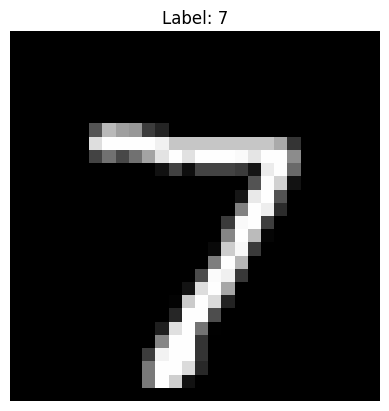

In [ ]:
import matplotlib.pyplot as plt

data_iter = iter(test_loader)
x, label_var = next(data_iter)

x = x[0]
label = label_var[0]

image = x.view(28, 28)

plt.imshow(image, cmap="gray")
plt.title("Label: {}".format(label))
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
net = net.to(device)
params_dict = {key: value.to(device) for key, value in params_dict.items()}
buffers_dict = {key: value.to(device) for key, value in buffers_dict.items()}
x = x.to(device)

In [ ]:
def model_fn_params_only(params_dict, buffers_dict):
    out = torch.func.functional_call(net, (params_dict, buffers_dict), x)
    return out, out

In [ ]:
n_params = len(parameters_to_vector(net.parameters()).detach())

In [ ]:
loss = 0
n_data = 0

In [ ]:
net.eval()
mean = parameters_to_vector(net.parameters())

In [ ]:
X, _ = next(iter(train_loader))

In [ ]:
with torch.no_grad():
    try:
        out = net(X[:1].to(device))
    except (TypeError, AttributeError):
        out = net(X.to(device))
n_outputs = out.shape[-1]

In [ ]:
setattr(net, "output_size", n_outputs)

In [ ]:
H = torch.zeros(_n_params_subnet, _n_params_subnet, device=device)

In [ ]:
def jacobians(x):
    def model_fn_params_only(params_dict, buffers_dict):
        out = torch.func.functional_call(net, (params_dict, buffers_dict), x)
        return out, out

    with torch.no_grad():
        Js, f = torch.func.jacrev(model_fn_params_only, has_aux=True)(
            params_dict, buffers_dict
        )

    Js = [
        j.flatten(start_dim=-p.dim()) for j, p in zip(Js.values(), params_dict.values())
    ]
    Js = torch.cat(Js, dim=-1)

    Js = Js[:, :, subnet_mask_indices]
    return Js, f

In [ ]:
from torch.nn import CrossEntropyLoss

In [ ]:
N = len(train_loader.dataset)
i = 0
for X, y in train_loader:
    i = i + 1
    if i % 1000 == 0:
        print(i)
    net.zero_grad()
    X, y = X.to(device), y.to(device)
    Js, f = jacobians(X)
    ps = torch.softmax(f, dim=-1)
    H_lik = torch.diag_embed(ps) - torch.einsum("mk,mc->mck", ps, ps)
    H_batch = torch.einsum("bcp,bck,bkq->pq", Js, H_lik, Js)
    lossfunc = CrossEntropyLoss(reduction="sum")
    loss_batch = 1.0 * lossfunc(f, y)
    loss += loss_batch
    H += H_batch
    del X, y, H_lik, H_batch, loss_batch

In [ ]:
H

tensor([[ 700.3990, -125.4198,  -42.3684,  ...,  -59.6776,  108.0632,
           41.5271],
        [-125.4198,  210.7474,   47.9255,  ...,   43.1763,  -79.8304,
          -33.4819],
        [ -42.3684,   47.9255,   41.5851,  ...,   11.4937,  -34.4630,
          -14.6852],
        ...,
        [ -59.6776,   43.1763,   11.4937,  ...,   58.4023,  -34.7992,
            6.0773],
        [ 108.0632,  -79.8304,  -34.4630,  ...,  -34.7992,  294.4118,
          225.3453],
        [  41.5271,  -33.4819,  -14.6852,  ...,    6.0773,  225.3453,
          358.3875]], device='cuda:0')

In [ ]:
sigma_noise = 1.0
temperature = 1.0

In [ ]:
sigma_noise = torch.tensor(sigma_noise, device=device)

In [ ]:
sigma2 = sigma_noise.square()
_H_factor = 1 / sigma2 / temperature

In [ ]:
len(H)

32

In [ ]:
from torch.distributions.multivariate_normal import _precision_to_scale_tril

In [ ]:
prior_precision = 1.
prior_precision_diag = torch.ones(_n_params_subnet, device=device)
posterior_precision = _H_factor * H + torch.diag(prior_precision_diag)
# posterior_precision = torch.diag(prior_precision_diag)
invsqrt_precision = _precision_to_scale_tril
posterior_scale = invsqrt_precision(posterior_precision)
scale = posterior_scale
posterior_covariance = scale @ scale.T
print(posterior_covariance.shape)

torch.Size([32, 32])


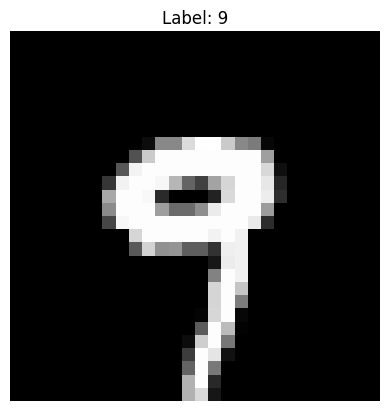

In [ ]:
data_iter = iter(train_loader)
x, label_var = next(data_iter)
x = x[0]
label = label_var[0]

image = x.view(28, 28)

plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.axis('off')  # Hide axes
plt.show()


x = x.to(device)

In [ ]:
with torch.no_grad():
    Js, f_mu = torch.func.jacrev(model_fn_params_only, has_aux=True)(params_dict, buffers_dict)

Js = [
    j.flatten(start_dim=-p.dim())
    for j, p in zip(Js.values(), params_dict.values())
]
Js = torch.cat(Js, dim=-1)

Js = Js[:, :, subnet_mask_indices]

Js = Js.squeeze(0)
f_var = torch.einsum('np,pq,mq->nm', Js, posterior_covariance, Js)
f_var = f_var.unsqueeze(0)
kappa = 1 / torch.sqrt(1. + torch.pi / 8 * f_var.diagonal(dim1=1, dim2=2))
final_ppd = torch.softmax(kappa * f_mu, dim=-1)
print(final_ppd)

tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.2320]], device='cuda:0')
